In [4]:
# =====================================================
#     Tên: Real Estate Price Prediction
#     Nghiên cứu khoa học: "Nghiên cứu tối ưu mô hình kết hợp
#     trong việc dự đoán giá nhà tại Hà Nội"
#     Mô hình sử dụng: Linear Regression & XGBoost
# =====================================================

In [5]:
# -------------------------------------------------
# 0. CÀI THƯ VIỆN (Colab cài mới nhất đã hỗ trợ GPU)
# -------------------------------------------------
!pip install -U xgboost optuna --quiet

In [ ]:
# -------------------------------------------------
# 1. IMPORT & ĐỌC DỮ LIỆU
# -------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# --- tải/đọc CSV ---
DATA_PATH = Path("data_processing.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Không tìm thấy file: {DATA_PATH}")
data = pd.read_csv(DATA_PATH)

target = "price"
y = data[target]
X = data.drop(columns=[target])

In [7]:
# -------------------------------------------------
# 2. TIỀN XỬ LÝ: ColumnTransformer + Pipeline
# -------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns  # 1‑hot district

preprocess = ColumnTransformer([
    ("num",  StandardScaler(),   num_cols),
    ("bool", "passthrough",      bool_cols)  # giữ nguyên 0/1
])

In [8]:
# -------------------------------------------------
# 3. ĐỊNH NGHĨA RMSLE & SCORER
# -------------------------------------------------
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    # Cắt giá trị về >= 0 để tránh log(âm)
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Tạo scorer cho cross_val_score,
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [9]:
# -------------------------------------------------
# 4. TÁCH TRAIN / TEST (80 % / 20 %)
# -------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# -------------------------------------------------
# 5. OPTUNA: TUNE XGBOOST GPU
# -------------------------------------------------
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"        : trial.suggest_int("max_depth", 4, 18),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma"            : trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha"        : trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda"       : trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1, 20),
        # --- BẬT GPU ---
        "tree_method"      : "gpu_hist",
        "predictor"        : "gpu_predictor",
        "gpu_id"           : 0,
        "random_state"     : 42,
    }

    model = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**params))
    ])

    # cross‑val 5 fold, tối thiểu RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-04-23 19:10:09,733] A new study created in memory with name: no-name-b4396545-9f23-4702-827b-f01d517d1e2a


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:12] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:12] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:12] WARNING: /workspace/src/common

[I 2025-04-23 19:10:32,586] Trial 0 finished with value: 0.3214216772947896 and parameters: {'n_estimators': 1181, 'max_depth': 13, 'learning_rate': 0.19327547173702983, 'subsample': 0.9018364115261392, 'colsample_bytree': 0.7350821577586467, 'gamma': 3.9670093045553005, 'reg_alpha': 2.472330908051749, 'reg_lambda': 9.62357122104674, 'min_child_weight': 1.9103594365327203}. Best is trial 0 with value: 0.3214216772947896.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:

[I 2025-04-23 19:11:39,227] Trial 1 finished with value: 0.4519935723614547 and parameters: {'n_estimators': 1150, 'max_depth': 18, 'learning_rate': 0.01742415466341063, 'subsample': 0.7324187093494473, 'colsample_bytree': 0.6141907121747313, 'gamma': 1.6301030256262798, 'reg_alpha': 1.5013219803808544, 'reg_lambda': 0.7054799513886243, 'min_child_weight': 16.647992818755498}. Best is trial 0 with value: 0.3214216772947896.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:

[I 2025-04-23 19:11:57,392] Trial 2 finished with value: 0.37752684425223176 and parameters: {'n_estimators': 1009, 'max_depth': 6, 'learning_rate': 0.07723938326526696, 'subsample': 0.7023907656069563, 'colsample_bytree': 0.9051306054017683, 'gamma': 0.2104131399882242, 'reg_alpha': 1.1510068859761045, 'reg_lambda': 1.6460403348007389, 'min_child_weight': 18.898360417994553}. Best is trial 0 with value: 0.3214216772947896.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:11:

[I 2025-04-23 19:12:15,242] Trial 3 finished with value: 0.3245778370797791 and parameters: {'n_estimators': 763, 'max_depth': 8, 'learning_rate': 0.015477258538216413, 'subsample': 0.7856309330102249, 'colsample_bytree': 0.7766127377915377, 'gamma': 4.4920056063477105, 'reg_alpha': 1.0815755254123567, 'reg_lambda': 7.740981645471441, 'min_child_weight': 11.917688491546105}. Best is trial 0 with value: 0.3214216772947896.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:

[I 2025-04-23 19:12:36,547] Trial 4 finished with value: 0.32199262863976597 and parameters: {'n_estimators': 834, 'max_depth': 9, 'learning_rate': 0.02671744262898698, 'subsample': 0.8870475999623957, 'colsample_bytree': 0.7994565900461548, 'gamma': 0.2898761162439878, 'reg_alpha': 0.47660664049908635, 'reg_lambda': 2.908926025314845, 'min_child_weight': 9.560074374304678}. Best is trial 0 with value: 0.3214216772947896.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:12:

[I 2025-04-23 19:13:00,022] Trial 5 finished with value: 0.46923311706104887 and parameters: {'n_estimators': 1202, 'max_depth': 16, 'learning_rate': 0.25796453257089796, 'subsample': 0.9012403887693766, 'colsample_bytree': 0.6592669734870307, 'gamma': 3.9930304750630157, 'reg_alpha': 0.7854406375603944, 'reg_lambda': 0.5445452611390749, 'min_child_weight': 7.504869183398757}. Best is trial 0 with value: 0.3214216772947896.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:

[I 2025-04-23 19:13:10,914] Trial 6 finished with value: 0.3470117339770156 and parameters: {'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.015352596479013849, 'subsample': 0.7680971586450192, 'colsample_bytree': 0.6245232419888517, 'gamma': 4.761146493317561, 'reg_alpha': 3.163037668632515, 'reg_lambda': 9.813774980352152, 'min_child_weight': 11.868213337707417}. Best is trial 0 with value: 0.3214216772947896.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:

[I 2025-04-23 19:13:40,469] Trial 7 finished with value: 0.31549074968205143 and parameters: {'n_estimators': 590, 'max_depth': 17, 'learning_rate': 0.05030895129702852, 'subsample': 0.9332074297831778, 'colsample_bytree': 0.9629775336072965, 'gamma': 2.5480606164583874, 'reg_alpha': 0.5028652728071036, 'reg_lambda': 5.28398214384243, 'min_child_weight': 7.879975450343084}. Best is trial 7 with value: 0.31549074968205143.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:

[I 2025-04-23 19:13:53,515] Trial 8 finished with value: 0.32102114106061835 and parameters: {'n_estimators': 623, 'max_depth': 7, 'learning_rate': 0.08546539339086043, 'subsample': 0.8203959433754773, 'colsample_bytree': 0.6464488299234555, 'gamma': 0.17959340779245325, 'reg_alpha': 3.2505618964189704, 'reg_lambda': 8.551452468837669, 'min_child_weight': 4.920950633331633}. Best is trial 7 with value: 0.31549074968205143.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:13:

[I 2025-04-23 19:14:15,158] Trial 9 finished with value: 0.3964093262167577 and parameters: {'n_estimators': 348, 'max_depth': 18, 'learning_rate': 0.23609299534850436, 'subsample': 0.916724439622764, 'colsample_bytree': 0.902876800987815, 'gamma': 0.10237645059944511, 'reg_alpha': 1.67589171400256, 'reg_lambda': 2.075354904094318, 'min_child_weight': 8.246961171241399}. Best is trial 7 with value: 0.31549074968205143.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:

[I 2025-04-23 19:14:38,172] Trial 10 finished with value: 0.3598353442099407 and parameters: {'n_estimators': 608, 'max_depth': 13, 'learning_rate': 0.044022390474182424, 'subsample': 0.9938598957434412, 'colsample_bytree': 0.9952742189488198, 'gamma': 2.6796511403449346, 'reg_alpha': 0.19533511347288102, 'reg_lambda': 0.13071180191255652, 'min_child_weight': 14.354267910855423}. Best is trial 7 with value: 0.31549074968205143.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:

[I 2025-04-23 19:14:48,927] Trial 11 finished with value: 0.29499119305247934 and parameters: {'n_estimators': 564, 'max_depth': 6, 'learning_rate': 0.09217011087168847, 'subsample': 0.6353530404926313, 'colsample_bytree': 0.9025952729666792, 'gamma': 2.1942387848904983, 'reg_alpha': 9.457824683093513, 'reg_lambda': 4.065847456680068, 'min_child_weight': 3.8232875086628955}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:14:

[I 2025-04-23 19:15:09,702] Trial 12 finished with value: 0.3039655950452135 and parameters: {'n_estimators': 1487, 'max_depth': 4, 'learning_rate': 0.11809472678497657, 'subsample': 0.6113945194866295, 'colsample_bytree': 0.9285720831159501, 'gamma': 2.327144382237993, 'reg_alpha': 7.912427688092885, 'reg_lambda': 4.219733597473789, 'min_child_weight': 3.7354571222641884}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:

[I 2025-04-23 19:15:30,396] Trial 13 finished with value: 0.3017212481945096 and parameters: {'n_estimators': 1469, 'max_depth': 4, 'learning_rate': 0.1223481920480206, 'subsample': 0.6060466072376047, 'colsample_bytree': 0.884701837645594, 'gamma': 1.636972443361119, 'reg_alpha': 8.93966260833378, 'reg_lambda': 3.8451220544493383, 'min_child_weight': 1.1298635077439299}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:

[I 2025-04-23 19:15:51,142] Trial 14 finished with value: 0.30285360961320557 and parameters: {'n_estimators': 1478, 'max_depth': 4, 'learning_rate': 0.11253756569835925, 'subsample': 0.6017909209016576, 'colsample_bytree': 0.8487804896967073, 'gamma': 1.3556610993941698, 'reg_alpha': 9.954951838985808, 'reg_lambda': 1.2161570665843249, 'min_child_weight': 1.4021715687633383}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:15:

[I 2025-04-23 19:16:12,486] Trial 15 finished with value: 0.34553462028116355 and parameters: {'n_estimators': 1307, 'max_depth': 5, 'learning_rate': 0.1576932398615345, 'subsample': 0.6651197895139922, 'colsample_bytree': 0.8725614474820484, 'gamma': 1.3016178362946427, 'reg_alpha': 5.403981609812744, 'reg_lambda': 0.3611845204826853, 'min_child_weight': 5.303398253409924}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:

[I 2025-04-23 19:16:28,145] Trial 16 finished with value: 0.2954132495140243 and parameters: {'n_estimators': 466, 'max_depth': 11, 'learning_rate': 0.0345680558832492, 'subsample': 0.6690162675723261, 'colsample_bytree': 0.8449049026498486, 'gamma': 3.206016842554093, 'reg_alpha': 5.569557768240551, 'reg_lambda': 3.4184667525489507, 'min_child_weight': 3.4922430117129872}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:

[I 2025-04-23 19:16:43,635] Trial 17 finished with value: 0.3241520747596804 and parameters: {'n_estimators': 479, 'max_depth': 11, 'learning_rate': 0.03160248632810217, 'subsample': 0.6662356752430847, 'colsample_bytree': 0.8347823358052151, 'gamma': 3.1470872958682046, 'reg_alpha': 5.0850322892887805, 'reg_lambda': 2.637243315327557, 'min_child_weight': 6.008231922355199}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:16:

[I 2025-04-23 19:17:08,553] Trial 18 finished with value: 0.31716821981155735 and parameters: {'n_estimators': 742, 'max_depth': 11, 'learning_rate': 0.029601366119430667, 'subsample': 0.6566386101221013, 'colsample_bytree': 0.7422402898360223, 'gamma': 3.4935430416316895, 'reg_alpha': 0.119625862109006, 'reg_lambda': 1.1935708536998633, 'min_child_weight': 3.809707252419938}. Best is trial 11 with value: 0.29499119305247934.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:

[I 2025-04-23 19:17:38,193] Trial 19 finished with value: 0.254243151728035 and parameters: {'n_estimators': 515, 'max_depth': 15, 'learning_rate': 0.0101682921889148, 'subsample': 0.8356781977689416, 'colsample_bytree': 0.9463992975150944, 'gamma': 2.071564189663436, 'reg_alpha': 5.260529842462634, 'reg_lambda': 5.095090734644497, 'min_child_weight': 3.148117109198969}. Best is trial 19 with value: 0.254243151728035.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:17:

[I 2025-04-23 19:18:18,803] Trial 20 finished with value: 0.3062201371717511 and parameters: {'n_estimators': 881, 'max_depth': 15, 'learning_rate': 0.011169540342849178, 'subsample': 0.8320248793351042, 'colsample_bytree': 0.9697996235308682, 'gamma': 2.0778367079620272, 'reg_alpha': 4.36760542055493, 'reg_lambda': 5.308499464958351, 'min_child_weight': 10.310431919930823}. Best is trial 19 with value: 0.254243151728035.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:

[I 2025-04-23 19:18:38,877] Trial 21 finished with value: 0.29888879013010616 and parameters: {'n_estimators': 465, 'max_depth': 14, 'learning_rate': 0.06338456747607736, 'subsample': 0.7228250393902015, 'colsample_bytree': 0.9280881916208129, 'gamma': 3.1681138297912312, 'reg_alpha': 6.696429346309343, 'reg_lambda': 3.418523070119358, 'min_child_weight': 3.4411072424361873}. Best is trial 19 with value: 0.254243151728035.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:

[I 2025-04-23 19:18:50,379] Trial 22 finished with value: 0.3083059028141343 and parameters: {'n_estimators': 305, 'max_depth': 12, 'learning_rate': 0.04173710627798921, 'subsample': 0.8598847699371628, 'colsample_bytree': 0.8387718158923202, 'gamma': 0.9242270256128675, 'reg_alpha': 2.519942592114209, 'reg_lambda': 5.524584030864379, 'min_child_weight': 6.460198085742639}. Best is trial 19 with value: 0.254243151728035.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:18:

[I 2025-04-23 19:19:08,213] Trial 23 finished with value: 0.24979755460552538 and parameters: {'n_estimators': 509, 'max_depth': 10, 'learning_rate': 0.010161371067036885, 'subsample': 0.7587601310416019, 'colsample_bytree': 0.9510812014442334, 'gamma': 2.0510291254230975, 'reg_alpha': 4.83830259851338, 'reg_lambda': 1.908202359539846, 'min_child_weight': 2.8429943315508774}. Best is trial 23 with value: 0.24979755460552538.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:

[I 2025-04-23 19:19:29,060] Trial 24 finished with value: 0.24618291588755778 and parameters: {'n_estimators': 713, 'max_depth': 9, 'learning_rate': 0.010124270630673959, 'subsample': 0.7588890628956796, 'colsample_bytree': 0.9578099502228464, 'gamma': 2.130911243706671, 'reg_alpha': 4.423882412818962, 'reg_lambda': 1.8765392851675935, 'min_child_weight': 2.5597229915077913}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:

[I 2025-04-23 19:19:49,016] Trial 25 finished with value: 0.2667715631708104 and parameters: {'n_estimators': 709, 'max_depth': 9, 'learning_rate': 0.010005656920229027, 'subsample': 0.7685042921423294, 'colsample_bytree': 0.9553477748203651, 'gamma': 0.7261910511338572, 'reg_alpha': 2.0804364917058216, 'reg_lambda': 1.8084799688244724, 'min_child_weight': 5.521692083294081}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:19:

[I 2025-04-23 19:20:19,157] Trial 26 finished with value: 0.26034382265475753 and parameters: {'n_estimators': 952, 'max_depth': 10, 'learning_rate': 0.021146215570595966, 'subsample': 0.8116088159154484, 'colsample_bytree': 0.9906499343014133, 'gamma': 1.8861273997025187, 'reg_alpha': 3.825919750842787, 'reg_lambda': 0.9543165758836542, 'min_child_weight': 2.244242498362539}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:20:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:20:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:20:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:20:

[I 2025-04-23 19:21:01,530] Trial 27 finished with value: 0.2713458754365937 and parameters: {'n_estimators': 705, 'max_depth': 15, 'learning_rate': 0.012535564883599588, 'subsample': 0.7442024323798491, 'colsample_bytree': 0.9414494688524083, 'gamma': 1.8239760007295023, 'reg_alpha': 3.5034908330692733, 'reg_lambda': 0.30188417915442733, 'min_child_weight': 2.801620217606653}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:

[I 2025-04-23 19:21:12,182] Trial 28 finished with value: 0.27201651579065544 and parameters: {'n_estimators': 426, 'max_depth': 8, 'learning_rate': 0.02343599147788792, 'subsample': 0.8586134227834815, 'colsample_bytree': 0.9760862982207381, 'gamma': 2.723457851077571, 'reg_alpha': 6.332415645037083, 'reg_lambda': 2.15413273562554, 'min_child_weight': 6.865884563054494}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:

[I 2025-04-23 19:21:39,413] Trial 29 finished with value: 0.25998720628368843 and parameters: {'n_estimators': 530, 'max_depth': 13, 'learning_rate': 0.01379288587214664, 'subsample': 0.7868025118999975, 'colsample_bytree': 0.932400513383381, 'gamma': 1.1431012743112134, 'reg_alpha': 2.2952306430455116, 'reg_lambda': 1.489925181401102, 'min_child_weight': 2.066453245183965}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:

[I 2025-04-23 19:22:05,997] Trial 30 finished with value: 0.30114483646462686 and parameters: {'n_estimators': 691, 'max_depth': 12, 'learning_rate': 0.019153652009779146, 'subsample': 0.7014155963583447, 'colsample_bytree': 0.8772866519104806, 'gamma': 2.7859115219091217, 'reg_alpha': 0.686576924638739, 'reg_lambda': 0.5517734220180806, 'min_child_weight': 4.77329022326294}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:

[I 2025-04-23 19:22:35,836] Trial 31 finished with value: 0.2468861354606246 and parameters: {'n_estimators': 532, 'max_depth': 13, 'learning_rate': 0.013295858307141578, 'subsample': 0.7774193205648281, 'colsample_bytree': 0.9361571076327762, 'gamma': 0.990937731991231, 'reg_alpha': 2.6059473303387737, 'reg_lambda': 1.4737036437767572, 'min_child_weight': 1.0219225710867872}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:22:

[I 2025-04-23 19:23:11,591] Trial 32 finished with value: 0.2482504909899795 and parameters: {'n_estimators': 517, 'max_depth': 14, 'learning_rate': 0.010455653427404562, 'subsample': 0.7542466671294031, 'colsample_bytree': 0.9484412870690389, 'gamma': 0.7136197364366612, 'reg_alpha': 2.586057739957897, 'reg_lambda': 0.9870954870549442, 'min_child_weight': 1.2844873273484894}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:

[I 2025-04-23 19:23:46,992] Trial 33 finished with value: 0.25385816010678747 and parameters: {'n_estimators': 637, 'max_depth': 13, 'learning_rate': 0.01288313493464469, 'subsample': 0.7467651716724583, 'colsample_bytree': 0.9121981808989938, 'gamma': 0.4656271186300813, 'reg_alpha': 2.6394841153166686, 'reg_lambda': 0.8196720174350004, 'min_child_weight': 1.0043464173441958}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:23:

[I 2025-04-23 19:24:00,561] Trial 34 finished with value: 0.24889157129906114 and parameters: {'n_estimators': 399, 'max_depth': 10, 'learning_rate': 0.016400266909395972, 'subsample': 0.7094106208281146, 'colsample_bytree': 0.9897704113706366, 'gamma': 0.5750254487285884, 'reg_alpha': 1.4144789330147136, 'reg_lambda': 1.3352663959349753, 'min_child_weight': 2.2322138130606626}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:

[I 2025-04-23 19:24:33,918] Trial 35 finished with value: 0.33574113812774986 and parameters: {'n_estimators': 809, 'max_depth': 14, 'learning_rate': 0.017395429627808857, 'subsample': 0.708080994011254, 'colsample_bytree': 0.9992786236851148, 'gamma': 0.6154880758612993, 'reg_alpha': 1.5276047173817067, 'reg_lambda': 0.6215008607432654, 'min_child_weight': 16.893071653103245}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:

[I 2025-04-23 19:24:51,334] Trial 36 finished with value: 0.2521221358843859 and parameters: {'n_estimators': 382, 'max_depth': 12, 'learning_rate': 0.016347648432476946, 'subsample': 0.721906276540268, 'colsample_bytree': 0.9770649072481312, 'gamma': 1.0057043584693643, 'reg_alpha': 1.078154179980032, 'reg_lambda': 1.2525865771554576, 'min_child_weight': 2.2262548261814326}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:24:

[I 2025-04-23 19:25:01,540] Trial 37 finished with value: 0.2727208308120964 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.02324649424563812, 'subsample': 0.7855558397428952, 'colsample_bytree': 0.9109915718171975, 'gamma': 1.529276190123499, 'reg_alpha': 1.8130273629027729, 'reg_lambda': 0.44244487388484366, 'min_child_weight': 4.5095700118395925}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:

[I 2025-04-23 19:25:21,491] Trial 38 finished with value: 0.257401499178069 and parameters: {'n_estimators': 797, 'max_depth': 8, 'learning_rate': 0.014313068489555809, 'subsample': 0.6895976187602125, 'colsample_bytree': 0.8079502341045093, 'gamma': 0.7786432069881011, 'reg_alpha': 0.7771403386780282, 'reg_lambda': 0.8088742945559949, 'min_child_weight': 1.8946209019222082}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:25:

[I 2025-04-23 19:26:20,760] Trial 39 finished with value: 0.37535011400409646 and parameters: {'n_estimators': 1051, 'max_depth': 16, 'learning_rate': 0.012542835971053953, 'subsample': 0.7413195192281531, 'colsample_bytree': 0.6935869110166489, 'gamma': 0.3565565507429851, 'reg_alpha': 1.1603909295634123, 'reg_lambda': 1.4797150865309763, 'min_child_weight': 8.724576398384702}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:

[I 2025-04-23 19:26:34,326] Trial 40 finished with value: 0.32666028225420973 and parameters: {'n_estimators': 646, 'max_depth': 7, 'learning_rate': 0.01768834389663809, 'subsample': 0.802456898332839, 'colsample_bytree': 0.766069838906488, 'gamma': 0.009762748107342123, 'reg_alpha': 1.3237990349970632, 'reg_lambda': 2.623199768300807, 'min_child_weight': 12.764951534669196}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:

[I 2025-04-23 19:26:52,924] Trial 41 finished with value: 0.24653017413616712 and parameters: {'n_estimators': 544, 'max_depth': 10, 'learning_rate': 0.011493163035613985, 'subsample': 0.7564060840418849, 'colsample_bytree': 0.9590060029233803, 'gamma': 1.073277933977891, 'reg_alpha': 3.014633359356593, 'reg_lambda': 2.0606988082461846, 'min_child_weight': 2.707106643797247}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:26:

[I 2025-04-23 19:27:08,112] Trial 42 finished with value: 0.25029207474642134 and parameters: {'n_estimators': 408, 'max_depth': 10, 'learning_rate': 0.011819217302265275, 'subsample': 0.7830469878985873, 'colsample_bytree': 0.9740003870054885, 'gamma': 0.5187959615358351, 'reg_alpha': 2.810889633501467, 'reg_lambda': 0.9865727666816683, 'min_child_weight': 2.353549660216605}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:

[I 2025-04-23 19:27:22,107] Trial 43 finished with value: 0.2621279912242581 and parameters: {'n_estimators': 562, 'max_depth': 8, 'learning_rate': 0.015555624369980633, 'subsample': 0.7613422107141489, 'colsample_bytree': 0.9627353280740926, 'gamma': 1.201991250914882, 'reg_alpha': 1.9353624796144884, 'reg_lambda': 2.35376326443021, 'min_child_weight': 4.372861749268368}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:

[I 2025-04-23 19:27:36,889] Trial 44 finished with value: 0.35018489972210853 and parameters: {'n_estimators': 572, 'max_depth': 9, 'learning_rate': 0.02017472183519951, 'subsample': 0.7222229849177126, 'colsample_bytree': 0.9209380487603293, 'gamma': 0.8976138872724206, 'reg_alpha': 3.7617435467184155, 'reg_lambda': 1.5073197722795206, 'min_child_weight': 19.58230690365796}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:27:

[I 2025-04-23 19:28:02,548] Trial 45 finished with value: 0.2592041086686714 and parameters: {'n_estimators': 369, 'max_depth': 14, 'learning_rate': 0.01393025956614851, 'subsample': 0.6900709009427782, 'colsample_bytree': 0.8923119192758564, 'gamma': 1.5292545998698903, 'reg_alpha': 3.0677686250967175, 'reg_lambda': 0.7827378656228393, 'min_child_weight': 1.0460456953968258}. Best is trial 24 with value: 0.24618291588755778.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:

[I 2025-04-23 19:28:22,092] Trial 46 finished with value: 0.23290208441677196 and parameters: {'n_estimators': 430, 'max_depth': 11, 'learning_rate': 0.011348147957411021, 'subsample': 0.773982528643232, 'colsample_bytree': 0.9860951127882205, 'gamma': 0.29524567592332773, 'reg_alpha': 1.362925377878702, 'reg_lambda': 1.236670700414804, 'min_child_weight': 1.7452205554297462}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:

[I 2025-04-23 19:28:54,884] Trial 47 finished with value: 0.24644118376980226 and parameters: {'n_estimators': 652, 'max_depth': 12, 'learning_rate': 0.011193572510375902, 'subsample': 0.7763617221196087, 'colsample_bytree': 0.9451232314281502, 'gamma': 0.2611672605131221, 'reg_alpha': 0.301483703209811, 'reg_lambda': 1.1018441217683121, 'min_child_weight': 1.5837166900269006}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:28:

[I 2025-04-23 19:29:21,524] Trial 48 finished with value: 0.2703832673587512 and parameters: {'n_estimators': 647, 'max_depth': 12, 'learning_rate': 0.011811683461166421, 'subsample': 0.7771125644547513, 'colsample_bytree': 0.9386007424173538, 'gamma': 0.24795151069620944, 'reg_alpha': 0.4578636572344007, 'reg_lambda': 1.6459267189790743, 'min_child_weight': 4.193620729233848}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:

[I 2025-04-23 19:29:57,022] Trial 49 finished with value: 0.29943690047698895 and parameters: {'n_estimators': 862, 'max_depth': 11, 'learning_rate': 0.014062599401494126, 'subsample': 0.7988120584945773, 'colsample_bytree': 0.6951158025880584, 'gamma': 0.2641989181592057, 'reg_alpha': 0.3096341158100641, 'reg_lambda': 0.1005756897653786, 'min_child_weight': 2.8147962236741533}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:29:

[I 2025-04-23 19:30:12,869] Trial 50 finished with value: 0.29332720484007824 and parameters: {'n_estimators': 767, 'max_depth': 7, 'learning_rate': 0.0257409471952531, 'subsample': 0.8323279794213639, 'colsample_bytree': 0.8700352646277643, 'gamma': 1.0719381639456056, 'reg_alpha': 0.20079090519321466, 'reg_lambda': 2.1106610828257715, 'min_child_weight': 7.096476096627546}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:30:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:30:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:30:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda

[I 2025-04-23 19:30:42,918] Trial 51 finished with value: 0.24635921551440557 and parameters: {'n_estimators': 586, 'max_depth': 12, 'learning_rate': 0.011047272519686239, 'subsample': 0.7534182506834991, 'colsample_bytree': 0.9513254948954135, 'gamma': 0.00979575210923167, 'reg_alpha': 0.9408626414488762, 'reg_lambda': 1.061860640479668, 'min_child_weight': 1.6064382655269271}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:30:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:30:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:30:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:30:

[I 2025-04-23 19:31:08,543] Trial 52 finished with value: 0.2346591985064775 and parameters: {'n_estimators': 597, 'max_depth': 11, 'learning_rate': 0.011406965877656605, 'subsample': 0.7987114619848477, 'colsample_bytree': 0.9794752280031759, 'gamma': 0.027012430730330605, 'reg_alpha': 0.57823053302348, 'reg_lambda': 1.1399502716737322, 'min_child_weight': 1.5145403146495817}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:

[I 2025-04-23 19:31:34,207] Trial 53 finished with value: 0.23467640940374865 and parameters: {'n_estimators': 594, 'max_depth': 11, 'learning_rate': 0.011440005082068353, 'subsample': 0.8010679435741699, 'colsample_bytree': 0.9848584904444063, 'gamma': 0.0795540894745632, 'reg_alpha': 0.529117587500186, 'reg_lambda': 1.113589898262256, 'min_child_weight': 1.6390428788267444}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:31:

[I 2025-04-23 19:32:02,918] Trial 54 finished with value: 0.2379253258723621 and parameters: {'n_estimators': 680, 'max_depth': 11, 'learning_rate': 0.015210886447778555, 'subsample': 0.8620618847375656, 'colsample_bytree': 0.9878427442620715, 'gamma': 0.009650870536188173, 'reg_alpha': 0.4103863987969985, 'reg_lambda': 0.6669894592291277, 'min_child_weight': 1.9077006412477617}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:

[I 2025-04-23 19:32:25,808] Trial 55 finished with value: 0.2642964471014616 and parameters: {'n_estimators': 601, 'max_depth': 11, 'learning_rate': 0.014735544593013048, 'subsample': 0.8835712771751072, 'colsample_bytree': 0.9857785138397179, 'gamma': 0.07482356130254941, 'reg_alpha': 0.5794714332887144, 'reg_lambda': 0.4472193253036456, 'min_child_weight': 3.172054554512668}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:

[I 2025-04-23 19:32:45,700] Trial 56 finished with value: 0.277660698691348 and parameters: {'n_estimators': 739, 'max_depth': 9, 'learning_rate': 0.017466032453190124, 'subsample': 0.8485379820573755, 'colsample_bytree': 0.9969055621056677, 'gamma': 4.1844149304228555, 'reg_alpha': 0.397869186650189, 'reg_lambda': 0.65949911054991, 'min_child_weight': 5.330179316275496}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:32:

[I 2025-04-23 19:33:02,976] Trial 57 finished with value: 0.29786589480431563 and parameters: {'n_estimators': 459, 'max_depth': 11, 'learning_rate': 0.06225575307282604, 'subsample': 0.9616932288401284, 'colsample_bytree': 0.9687539841651219, 'gamma': 0.024390417532770166, 'reg_alpha': 0.8944887371930075, 'reg_lambda': 0.24602623862977024, 'min_child_weight': 3.7802784105428113}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:

[I 2025-04-23 19:33:14,943] Trial 58 finished with value: 0.27115341827293526 and parameters: {'n_estimators': 672, 'max_depth': 12, 'learning_rate': 0.18298768524447293, 'subsample': 0.8934858652383602, 'colsample_bytree': 0.9797330401775081, 'gamma': 0.44206389363737697, 'reg_alpha': 0.6025939460378948, 'reg_lambda': 0.8774934736933508, 'min_child_weight': 1.7985791545491567}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:

[I 2025-04-23 19:33:45,622] Trial 59 finished with value: 0.32301919301730303 and parameters: {'n_estimators': 924, 'max_depth': 11, 'learning_rate': 0.011151268254298248, 'subsample': 0.8160332800816167, 'colsample_bytree': 0.9633019562590397, 'gamma': 0.18386928226347718, 'reg_alpha': 0.37230506389039714, 'reg_lambda': 0.7300346079342845, 'min_child_weight': 15.10428430821182}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:33:

[I 2025-04-23 19:34:03,302] Trial 60 finished with value: 0.2555214401387645 and parameters: {'n_estimators': 610, 'max_depth': 9, 'learning_rate': 0.010060208516557588, 'subsample': 0.7970779228063146, 'colsample_bytree': 0.9250766916109605, 'gamma': 0.4014690886551165, 'reg_alpha': 0.24512139651241796, 'reg_lambda': 1.1274027938435363, 'min_child_weight': 3.307134593669204}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:

[I 2025-04-23 19:34:37,691] Trial 61 finished with value: 0.23398448140981495 and parameters: {'n_estimators': 676, 'max_depth': 12, 'learning_rate': 0.011581166535830559, 'subsample': 0.8765207162498075, 'colsample_bytree': 0.9816884512694742, 'gamma': 0.20046270525080415, 'reg_alpha': 0.2697491273180523, 'reg_lambda': 1.1022488894408804, 'min_child_weight': 1.7614114618858676}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:34:

[I 2025-04-23 19:35:16,609] Trial 62 finished with value: 0.23664906842143477 and parameters: {'n_estimators': 726, 'max_depth': 12, 'learning_rate': 0.012705341447630077, 'subsample': 0.9196542335171782, 'colsample_bytree': 0.9994018900651589, 'gamma': 0.12928676940458456, 'reg_alpha': 0.13207663795204777, 'reg_lambda': 0.5520402562588035, 'min_child_weight': 1.640431219965969}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:

[I 2025-04-23 19:35:54,259] Trial 63 finished with value: 0.25902243217489157 and parameters: {'n_estimators': 733, 'max_depth': 13, 'learning_rate': 0.01287161182578973, 'subsample': 0.9131535902925391, 'colsample_bytree': 0.9850348196161706, 'gamma': 4.746736152865973, 'reg_alpha': 0.11568220954184569, 'reg_lambda': 0.4551843306176374, 'min_child_weight': 2.511345341299256}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:35:

[I 2025-04-23 19:36:22,616] Trial 64 finished with value: 0.26920344446456573 and parameters: {'n_estimators': 783, 'max_depth': 11, 'learning_rate': 0.015089121682575046, 'subsample': 0.9429960858468364, 'colsample_bytree': 0.9984867083526574, 'gamma': 3.6787542277054412, 'reg_alpha': 0.14711523404448137, 'reg_lambda': 0.5879381964348364, 'min_child_weight': 3.904558309969799}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:36:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:36:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:36:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:36:

[I 2025-04-23 19:37:10,825] Trial 65 finished with value: 0.2451596778738121 and parameters: {'n_estimators': 838, 'max_depth': 13, 'learning_rate': 0.018495558839714564, 'subsample': 0.8774826681832439, 'colsample_bytree': 0.97919137846516, 'gamma': 0.1776348905998368, 'reg_alpha': 0.148341769027853, 'reg_lambda': 0.29673533902202215, 'min_child_weight': 1.7881219353351703}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:

[I 2025-04-23 19:37:58,636] Trial 66 finished with value: 0.24675912948809434 and parameters: {'n_estimators': 826, 'max_depth': 13, 'learning_rate': 0.019176979186315838, 'subsample': 0.8748275024748937, 'colsample_bytree': 0.9783045807088343, 'gamma': 0.16056161033752497, 'reg_alpha': 0.15161015024479738, 'reg_lambda': 0.2543441215707246, 'min_child_weight': 1.6084028761165439}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:37:

[I 2025-04-23 19:38:40,706] Trial 67 finished with value: 0.28141117298359586 and parameters: {'n_estimators': 1047, 'max_depth': 12, 'learning_rate': 0.022788004444263755, 'subsample': 0.9293969419346214, 'colsample_bytree': 0.987008741787888, 'gamma': 0.6259084369209709, 'reg_alpha': 0.10029354541173176, 'reg_lambda': 0.18860414649752194, 'min_child_weight': 3.157986535835107}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:38:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:38:

[I 2025-04-23 19:39:09,151] Trial 68 finished with value: 0.32487552777863965 and parameters: {'n_estimators': 862, 'max_depth': 11, 'learning_rate': 0.01868666728809304, 'subsample': 0.8695153662481915, 'colsample_bytree': 0.9690043302384203, 'gamma': 0.3560244377128277, 'reg_alpha': 0.18707613006957793, 'reg_lambda': 0.3228063251446327, 'min_child_weight': 11.505025535209814}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:

[I 2025-04-23 19:39:42,572] Trial 69 finished with value: 0.24976307201330217 and parameters: {'n_estimators': 948, 'max_depth': 13, 'learning_rate': 0.028272623173303882, 'subsample': 0.9716899174201304, 'colsample_bytree': 0.9984662680766674, 'gamma': 0.7922655554222282, 'reg_alpha': 0.2753192460125069, 'reg_lambda': 0.5176084103890612, 'min_child_weight': 1.7358246021530324}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:39:

[I 2025-04-23 19:40:03,974] Trial 70 finished with value: 0.29105475318342827 and parameters: {'n_estimators': 710, 'max_depth': 10, 'learning_rate': 0.03989375973552927, 'subsample': 0.9052087321103227, 'colsample_bytree': 0.9710002085254876, 'gamma': 0.16932704027175904, 'reg_alpha': 0.382553288968251, 'reg_lambda': 0.38895177341016896, 'min_child_weight': 5.155494924568247}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:

[I 2025-04-23 19:40:33,099] Trial 71 finished with value: 0.32010210686806995 and parameters: {'n_estimators': 685, 'max_depth': 11, 'learning_rate': 0.012562410703450027, 'subsample': 0.8473748807729629, 'colsample_bytree': 0.6078989398358585, 'gamma': 0.4535110237459568, 'reg_alpha': 0.47130776289607834, 'reg_lambda': 1.3248542365688312, 'min_child_weight': 2.456390785425213}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:

[I 2025-04-23 19:41:18,088] Trial 72 finished with value: 0.2508220960130455 and parameters: {'n_estimators': 759, 'max_depth': 14, 'learning_rate': 0.015934695374163033, 'subsample': 0.8941440098732496, 'colsample_bytree': 0.9576795174555578, 'gamma': 2.3572995445908447, 'reg_alpha': 0.14704944017990462, 'reg_lambda': 0.17283525296043592, 'min_child_weight': 1.0044663179166964}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:

[I 2025-04-23 19:41:42,138] Trial 73 finished with value: 0.248731234652012 and parameters: {'n_estimators': 483, 'max_depth': 12, 'learning_rate': 0.012101366578456303, 'subsample': 0.8262710171940351, 'colsample_bytree': 0.9856641128987995, 'gamma': 0.29855518932153335, 'reg_alpha': 0.22544082675036456, 'reg_lambda': 0.9249811219926652, 'min_child_weight': 2.041214127616099}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:

[I 2025-04-23 19:42:06,337] Trial 74 finished with value: 0.2468378988867018 and parameters: {'n_estimators': 721, 'max_depth': 10, 'learning_rate': 0.013273338325137442, 'subsample': 0.9231144745459411, 'colsample_bytree': 0.9547511703369882, 'gamma': 0.1345167731401603, 'reg_alpha': 0.6131824702347701, 'reg_lambda': 1.751717170103655, 'min_child_weight': 2.9612837130605536}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:

[I 2025-04-23 19:42:41,531] Trial 75 finished with value: 0.26068108870652723 and parameters: {'n_estimators': 675, 'max_depth': 13, 'learning_rate': 0.010587586445269711, 'subsample': 0.8418089323205429, 'colsample_bytree': 0.9809414681460376, 'gamma': 0.599509838773999, 'reg_alpha': 0.1693146805814488, 'reg_lambda': 0.7013949000784558, 'min_child_weight': 3.5662852134139387}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:42:

[I 2025-04-23 19:43:18,487] Trial 76 finished with value: 0.24672772891249828 and parameters: {'n_estimators': 813, 'max_depth': 12, 'learning_rate': 0.014469060876321275, 'subsample': 0.8644641581837138, 'colsample_bytree': 0.9369295082786187, 'gamma': 2.9584603503824485, 'reg_alpha': 0.33907275283014765, 'reg_lambda': 1.25732807140729, 'min_child_weight': 1.7045886629712965}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:43:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:43:

[I 2025-04-23 19:44:09,142] Trial 77 finished with value: 0.26776515706605786 and parameters: {'n_estimators': 1322, 'max_depth': 11, 'learning_rate': 0.01678100826844082, 'subsample': 0.8797447654480082, 'colsample_bytree': 0.966181124313577, 'gamma': 0.32875211362259377, 'reg_alpha': 0.5396795825091634, 'reg_lambda': 0.5235392535845735, 'min_child_weight': 2.5295570806849663}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:

[I 2025-04-23 19:44:24,851] Trial 78 finished with value: 0.2600292751584604 and parameters: {'n_estimators': 438, 'max_depth': 10, 'learning_rate': 0.01008108763755036, 'subsample': 0.8095683310837785, 'colsample_bytree': 0.9915780390720449, 'gamma': 0.8374860471852275, 'reg_alpha': 0.719596382202314, 'reg_lambda': 0.8570738101130426, 'min_child_weight': 4.208202801379144}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:

[I 2025-04-23 19:44:58,524] Trial 79 finished with value: 0.24318998076017664 and parameters: {'n_estimators': 620, 'max_depth': 12, 'learning_rate': 0.0119169257479227, 'subsample': 0.8561509036097303, 'colsample_bytree': 0.9432837126790312, 'gamma': 0.012584839534165324, 'reg_alpha': 0.43676447304511645, 'reg_lambda': 0.7417628940908831, 'min_child_weight': 1.4314881314754833}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:44:

[I 2025-04-23 19:45:32,656] Trial 80 finished with value: 0.23627509328954305 and parameters: {'n_estimators': 493, 'max_depth': 13, 'learning_rate': 0.013321393347666211, 'subsample': 0.9430588702430055, 'colsample_bytree': 0.9998830166490354, 'gamma': 0.008774713126442957, 'reg_alpha': 0.4303218654687004, 'reg_lambda': 0.722194128091705, 'min_child_weight': 1.3581147406037555}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:45:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:45:

[I 2025-04-23 19:46:13,698] Trial 81 finished with value: 0.2372481795506179 and parameters: {'n_estimators': 620, 'max_depth': 13, 'learning_rate': 0.011952291164045004, 'subsample': 0.9447059360899135, 'colsample_bytree': 0.9981948206638637, 'gamma': 0.1022603568986124, 'reg_alpha': 0.4476695714679798, 'reg_lambda': 0.7470853681146455, 'min_child_weight': 1.5678736949476715}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:46:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:46:

[I 2025-04-23 19:47:02,379] Trial 82 finished with value: 0.24031279965214333 and parameters: {'n_estimators': 621, 'max_depth': 14, 'learning_rate': 0.011970085303326095, 'subsample': 0.9596823503258953, 'colsample_bytree': 0.9971934007458698, 'gamma': 0.053026434896325574, 'reg_alpha': 0.4126883915181299, 'reg_lambda': 0.7328519462958172, 'min_child_weight': 1.3791146060400887}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:

[I 2025-04-23 19:47:36,508] Trial 83 finished with value: 0.25691557910028906 and parameters: {'n_estimators': 505, 'max_depth': 14, 'learning_rate': 0.013414480702627326, 'subsample': 0.9457263293893526, 'colsample_bytree': 0.9974362400334762, 'gamma': 0.5292823469583292, 'reg_alpha': 0.5125970338370823, 'reg_lambda': 0.6381246025184778, 'min_child_weight': 2.202253756947199}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:47:

[I 2025-04-23 19:48:20,938] Trial 84 finished with value: 0.24930776986197833 and parameters: {'n_estimators': 554, 'max_depth': 15, 'learning_rate': 0.01538753317526995, 'subsample': 0.9986319354470358, 'colsample_bytree': 0.9995381794808252, 'gamma': 0.3666498599468499, 'reg_alpha': 0.4088977899130012, 'reg_lambda': 0.9141681988214021, 'min_child_weight': 1.0008551256436107}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:48:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:48:

[I 2025-04-23 19:49:02,721] Trial 85 finished with value: 0.24289509109231053 and parameters: {'n_estimators': 491, 'max_depth': 14, 'learning_rate': 0.011026163335275618, 'subsample': 0.9669532829745761, 'colsample_bytree': 0.9720767355120321, 'gamma': 0.1361504674339419, 'reg_alpha': 0.3407945708754678, 'reg_lambda': 1.003638608613109, 'min_child_weight': 1.4882644933096885}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:

[I 2025-04-23 19:49:10,088] Trial 86 finished with value: 0.29712824154269873 and parameters: {'n_estimators': 332, 'max_depth': 16, 'learning_rate': 0.2916094681698418, 'subsample': 0.9810456683629787, 'colsample_bytree': 0.9873162334607498, 'gamma': 0.6860533335101832, 'reg_alpha': 0.25437732782263, 'reg_lambda': 0.4930412012657676, 'min_child_weight': 2.9724569309070787}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:

[I 2025-04-23 19:49:45,088] Trial 87 finished with value: 0.2579707789853238 and parameters: {'n_estimators': 585, 'max_depth': 13, 'learning_rate': 0.012127591861083295, 'subsample': 0.9415198190864591, 'colsample_bytree': 0.9622614615107844, 'gamma': 0.25048015128446477, 'reg_alpha': 0.6688692421711799, 'reg_lambda': 0.5879375734678866, 'min_child_weight': 2.1694708268432024}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:49:

[I 2025-04-23 19:50:13,682] Trial 88 finished with value: 0.3816860988332148 and parameters: {'n_estimators': 626, 'max_depth': 15, 'learning_rate': 0.0945501125222114, 'subsample': 0.9541771768857394, 'colsample_bytree': 0.6306216681996215, 'gamma': 0.4796475294443261, 'reg_alpha': 0.3411845816067174, 'reg_lambda': 0.6857652477793097, 'min_child_weight': 3.3274238441490063}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:

[I 2025-04-23 19:50:33,062] Trial 89 finished with value: 0.2877676570172006 and parameters: {'n_estimators': 437, 'max_depth': 12, 'learning_rate': 0.013891668959839166, 'subsample': 0.9801177919371604, 'colsample_bytree': 0.9878602333033414, 'gamma': 0.09944792158286225, 'reg_alpha': 0.5265175657709307, 'reg_lambda': 0.7973314477582077, 'min_child_weight': 8.947237973433399}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:50:

[I 2025-04-23 19:51:03,408] Trial 90 finished with value: 0.2955522399464553 and parameters: {'n_estimators': 547, 'max_depth': 13, 'learning_rate': 0.011427766522259616, 'subsample': 0.911934626199546, 'colsample_bytree': 0.8029527696300077, 'gamma': 0.2689279206068484, 'reg_alpha': 1.2187475226199878, 'reg_lambda': 1.1548305961818812, 'min_child_weight': 4.669913459680955}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:

[I 2025-04-23 19:51:45,009] Trial 91 finished with value: 0.24162329694694923 and parameters: {'n_estimators': 484, 'max_depth': 14, 'learning_rate': 0.010717381114196367, 'subsample': 0.9627952613342298, 'colsample_bytree': 0.9729472744349105, 'gamma': 0.08385708169170025, 'reg_alpha': 0.3010245031590255, 'reg_lambda': 1.0214222430852467, 'min_child_weight': 1.4353130912841594}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:51:

[I 2025-04-23 19:52:24,161] Trial 92 finished with value: 0.24158934875510663 and parameters: {'n_estimators': 526, 'max_depth': 14, 'learning_rate': 0.012853780677432558, 'subsample': 0.9574797682893593, 'colsample_bytree': 0.9767535761350132, 'gamma': 0.029326774659888935, 'reg_alpha': 0.8505416697350006, 'reg_lambda': 1.3983582761746203, 'min_child_weight': 1.2378233663658407}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:

[I 2025-04-23 19:52:50,518] Trial 93 finished with value: 0.2481472954908761 and parameters: {'n_estimators': 664, 'max_depth': 11, 'learning_rate': 0.012927444633831539, 'subsample': 0.9335892151705072, 'colsample_bytree': 0.9900266050056827, 'gamma': 0.015812672339094017, 'reg_alpha': 0.7690985747892705, 'reg_lambda': 1.1872452300923304, 'min_child_weight': 2.066177027457978}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:

[I 2025-04-23 19:53:15,675] Trial 94 finished with value: 0.25552461456148634 and parameters: {'n_estimators': 526, 'max_depth': 12, 'learning_rate': 0.014580254475663298, 'subsample': 0.9517168154937247, 'colsample_bytree': 0.9516259839441176, 'gamma': 0.3889607569584646, 'reg_alpha': 1.0205370460685912, 'reg_lambda': 1.597796077889953, 'min_child_weight': 2.7853266382051274}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:

[I 2025-04-23 19:53:50,178] Trial 95 finished with value: 0.24431829674296246 and parameters: {'n_estimators': 580, 'max_depth': 13, 'learning_rate': 0.01577298025025107, 'subsample': 0.9845305608677105, 'colsample_bytree': 0.9815785342739053, 'gamma': 0.21942409753284878, 'reg_alpha': 0.846660725392393, 'reg_lambda': 1.3636109674209553, 'min_child_weight': 1.334619015090952}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:53:

[I 2025-04-23 19:54:20,325] Trial 96 finished with value: 0.3224553888774921 and parameters: {'n_estimators': 604, 'max_depth': 14, 'learning_rate': 0.01228557966319626, 'subsample': 0.9051107877251716, 'colsample_bytree': 0.9607404024447497, 'gamma': 0.5606074104971559, 'reg_alpha': 0.4354127066578318, 'reg_lambda': 0.3944917424757124, 'min_child_weight': 17.156221716711762}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:

[I 2025-04-23 19:54:56,335] Trial 97 finished with value: 0.24350940566841764 and parameters: {'n_estimators': 451, 'max_depth': 15, 'learning_rate': 0.020625838914478656, 'subsample': 0.9235446635641065, 'colsample_bytree': 0.9994070100462937, 'gamma': 0.10422532670355043, 'reg_alpha': 0.5692991548952794, 'reg_lambda': 0.5801041654832689, 'min_child_weight': 1.947216981701365}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:

[I 2025-04-23 19:55:22,543] Trial 98 finished with value: 0.2553379258465959 and parameters: {'n_estimators': 632, 'max_depth': 11, 'learning_rate': 0.01340637602490896, 'subsample': 0.9567836602462928, 'colsample_bytree': 0.9751858714756994, 'gamma': 0.31556420181391015, 'reg_alpha': 0.49769126170757494, 'reg_lambda': 0.7686688720285242, 'min_child_weight': 2.4994833466378505}. Best is trial 46 with value: 0.23290208441677196.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:55:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:55:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:55:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:55:

[I 2025-04-23 19:55:55,589] Trial 99 finished with value: 0.23890050593465623 and parameters: {'n_estimators': 563, 'max_depth': 12, 'learning_rate': 0.011243982841684099, 'subsample': 0.9891060624106492, 'colsample_bytree': 0.9916970960510411, 'gamma': 0.005111973510292944, 'reg_alpha': 0.6247527283496397, 'reg_lambda': 0.8640689555823967, 'min_child_weight': 1.3949994367749572}. Best is trial 46 with value: 0.23290208441677196.
Best RMSLE (CV): 0.23290208441677196
Best params: {'n_estimators': 430, 'max_depth': 11, 'learning_rate': 0.011348147957411021, 'subsample': 0.773982528643232, 'colsample_bytree': 0.9860951127882205, 'gamma': 0.29524567592332773, 'reg_alpha': 1.362925377878702, 'reg_lambda': 1.236670700414804, 'min_child_weight': 1.7452205554297462}


In [11]:
# -------------------------------------------------
# 6. HUẤN LUYỆN MÔ HÌNH TỐI ƯU & SO SÁNH VỚI LINEAR REG
# -------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 6.1 XGB Pipeline với tham số tốt nhất
xgb_model = Pipeline([
    ("prep", preprocess),
    ("xgb",  XGBRegressor(**study.best_params))
]).fit(X_train, y_train)

# 6.2 Linear Regression (có scaler sẵn trong preprocess)
lr_model = Pipeline([
    ("prep", preprocess),
    ("lr",   LinearRegression())
]).fit(X_train, y_train)

# 6.3 Dự báo & đánh giá
def evaluate(name, y_true, y_pred, k):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1)/(len(y_true) - k - 1))
    print(f"\n{name}")
    print("-"*30)
    print(f"RMSE : {rmse:,.3f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.3f}")
    print(f"R²   : {r2:.4f} | Adj‑R²: {adj_r2:.4f}")

xgb_pred = xgb_model.predict(X_test)
lr_pred  = lr_model.predict(X_test)

k_features = X_train.shape[1]
evaluate("XGBoost GPU", y_test, xgb_pred, k=k_features)
evaluate("Linear Regression", y_test, lr_pred, k=k_features)


XGBoost GPU
------------------------------
RMSE : 19.822
RMSLE: 0.213
R²   : 0.8347 | Adj‑R²: 0.8339

Linear Regression
------------------------------
RMSE : 37.304
RMSLE: 0.870
R²   : 0.4147 | Adj‑R²: 0.4117


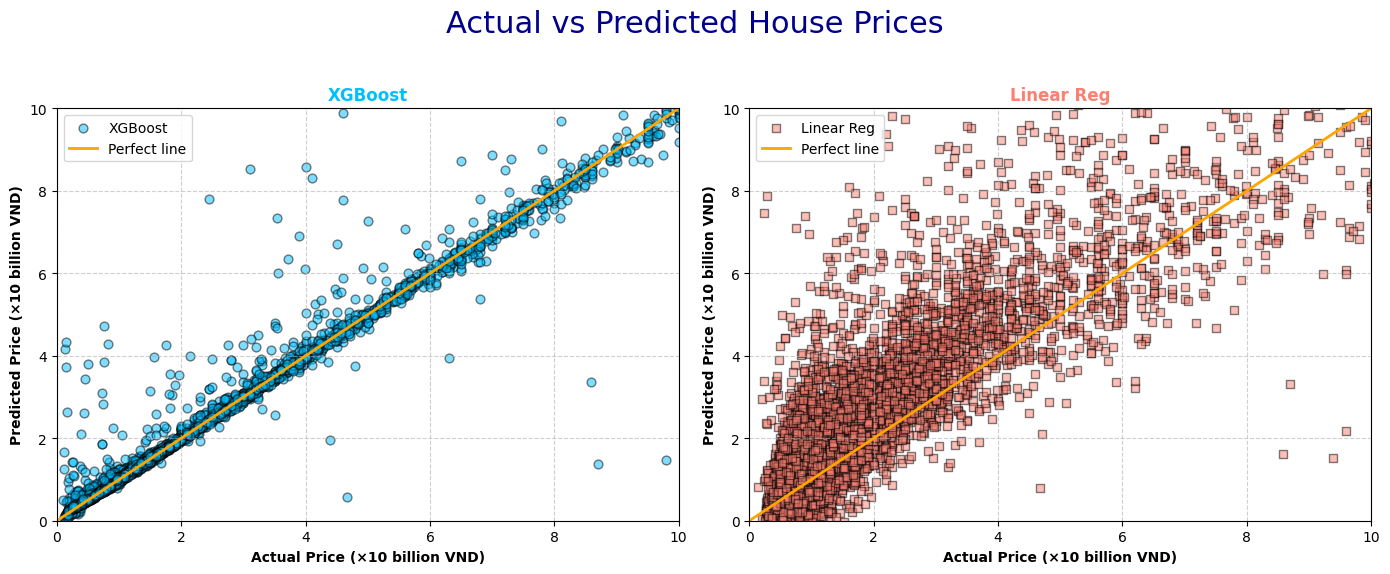

In [12]:
# -------------------------------------------------
# 7. MINH HỌA SCATTER ACTUAL vs PREDICTED
# -------------------------------------------------
import matplotlib.pyplot as plt

models = [("XGBoost", xgb_pred, "deepskyblue", "o"),
          ("Linear Reg", lr_pred, "salmon", "s")]

plt.figure(figsize=(14,6))
for i, (name, pred, color, marker) in enumerate(models, 1):
    plt.subplot(1,3,i)
    plt.scatter(y_test/10, pred/10, c=color, marker=marker,
                s=40, edgecolors="black", alpha=0.5, label=name)
    plt.plot([0,10], [0,10], "orange", lw=2, label="Perfect line")
    plt.xlim(0,10); plt.ylim(0,10)
    plt.xlabel("Actual Price (×10 billion VND)", fontweight="bold")
    plt.ylabel("Predicted Price (×10 billion VND)", fontweight="bold")
    plt.title(name, fontweight="bold", color=color)
    plt.grid(ls="--", alpha=0.6); plt.legend()

plt.suptitle("Actual vs Predicted House Prices", fontsize=22, color="darkblue")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [13]:
# -------------------------------------------------
# 8. IMPORT THƯ VIỆN
# -------------------------------------------------

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import numpy as np

In [14]:
# -------------------------------------------------
# 9. BASE MODEL (đều bọc trong pipeline có 'prep')
# -------------------------------------------------
xgb_pipe = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**study.best_params))
])

lin_pipe = Pipeline([
        ("prep", preprocess),
        ("lr",   LinearRegression())
])

In [15]:
# -------------------------------------------------
# 10. META‑MODEL  (RidgeCV cho chắc chắn)
# -------------------------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3,3,13))

In [16]:
# -------------------------------------------------
# 11. STACKING REGRESSION  (K=10 fold, shuffle)
# -------------------------------------------------
stack = StackingRegressor(
        estimators=[('xgb', xgb_pipe),
                    ('lin', lin_pipe)],
        final_estimator=meta_model,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
        passthrough=False    # chỉ dùng dự báo base model
)

In [17]:
# -------------------------------------------------
# 12. HUẤN LUYỆN
# -------------------------------------------------
stack.fit(X_train, y_train)


StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('xgb',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 Index(['price_per_m2', 'area', 'floors', 'toilets', 'bedrooms', 'balcony',
       'street_frontage', 'legal', 'interior', 'year', 'month', 'day'],
      dtype='object')),
                                                                                ('bool',
                                                                                 'passthrough',
                                                                                 Index(['distric...
       'district_ThanhXuan', 'district_ThuongTin', 'district_UngHoa'],
      dtype='object'))])),
                                               ('lr', LinearRegression())]))],
                  final_estimator=RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])),
                  n_jobs=-1)

In [18]:
# -------------------------------------------------
# 13. ĐÁNH GIÁ DỰA TRÊN TẬP TEST
# -------------------------------------------------
pred_test = stack.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, pred_test))
rmsle = np.sqrt(mean_squared_log_error(
                    np.clip(y_test, 0, None)+1,
                    np.clip(pred_test, 0, None)+1))
r2    = r2_score(y_test, pred_test)

print(f"RMSE  : {rmse:,.3f}")
print(f"RMSLE : {rmsle:.3f}")
print(f"R²    : {r2:.4f}")

RMSE  : 20.160
RMSLE : 0.227
R²    : 0.8291


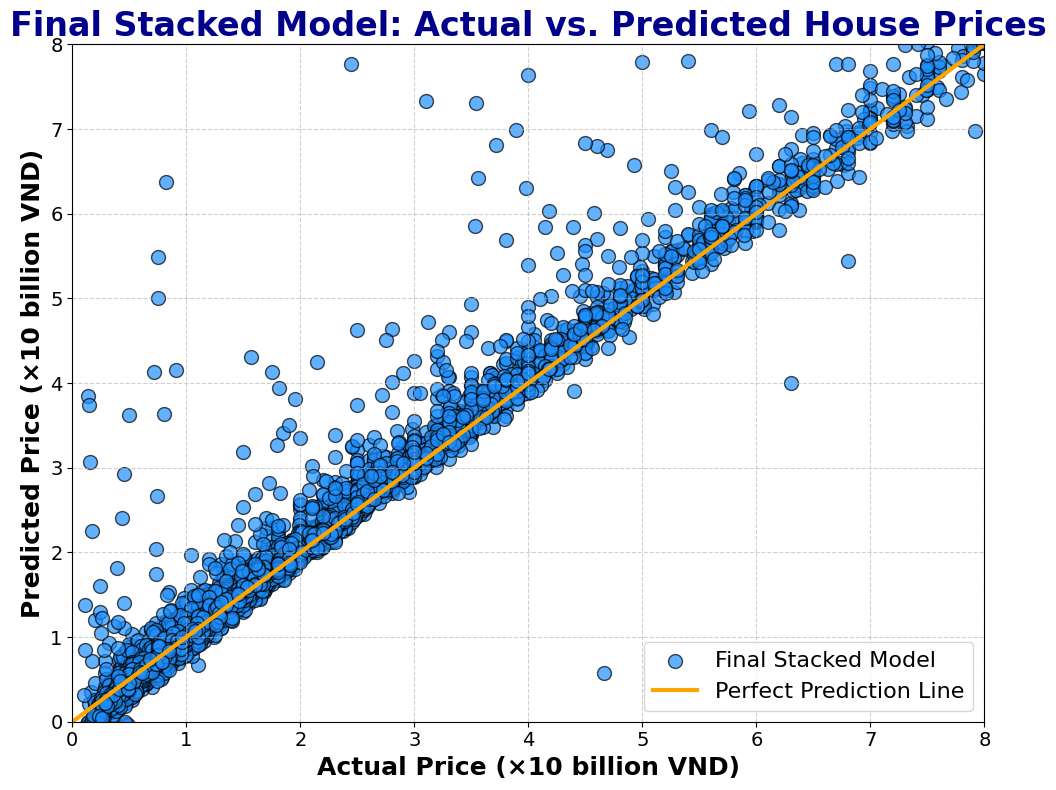

In [22]:
# -------------------------------------------------
# 14. VẼ SCATTER
# -------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title("Final Stacked Model: Actual vs. Predicted House Prices", fontsize=24, fontweight='bold', color='darkblue')

plt.scatter(y_test / 10, pred_test / 10,
            color='dodgerblue', marker='o', edgecolors="black", alpha=0.7, s=100, label="Final Stacked Model")

plt.plot([0, 8], [0, 8], "orange", lw=3, label="Perfect Prediction Line")

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel("Actual Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
# -------------------------------------------------
# 15. TRIỂN KHAI
# -------------------------------------------------
deploy_pred = stack.predict(X_test)
pd.DataFrame({"Price": deploy_pred}) \
  .to_csv("Submission_Stack_(Xgb+Lr).csv", index=False)

print("Saved file: Submission_Stack_(Xgb+Lr).csv")

Saved file: Submission_Stack.csv
